In [138]:
# Plan of Action
# plot all tackle distance data to determine methodology for picking playmaking threshold
    # Find distance between tackler and ball when ball carrier gets ball
# come up with cone of influence equation 
# distance delta pipeline


 #cone is where the defender could make the tackle

# ONLY LOOK AT RUN PLAYS FOR NOW
# Chase down efficiency
    # How well does each defender's cone move towards the ball carrier
        # Have a minimum distance to be able to be considered for the play
            # distribution of tackler's distance moved from play, get the upper quartile as the min distance
        # How do we judge how effectively they move there?
            # is it just distance delta?
                # consider derivative of distance over time as metric in concern
            # is it moving to final tackle location
            # is it cone overlap delta?

# Once cone overlap reaches threshold, chaser converts to prospective tackler
    # Use this to consider conversion rates for chasers

# Tackle probability - for all prospective tacklers
    # after ball carrier is in cone, how well does tackler make tackle
        # cone overlap integral
        # how fast does cone overlap area increase
        # 
##

#bivariate distribution - x is normally distributed, y is skewed distributed
# these distributions are centered on the player's location and have stdev of some formula of velocity and weight
#the combined distribution comes from multipying the x and y distribution because we're assuming independence


In [139]:
#how stdev affected by velocity
#1. sort by position
#2. bin by velocity
# -- check if we have enough data
#3. find stdev for each bin
#4. find trend for stdev across velocity bins

In [140]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import math
import matplotlib.pyplot as plt

In [141]:
# Game info - id, week, date, time, teams, scores
games = pd.read_csv("games.csv")


In [142]:
plays = pd.read_csv("plays.csv")
plays['gameClockSeconds'] = pd.to_datetime(plays['gameClock'], format='%M:%S').dt.minute * 60 + pd.to_datetime(plays['gameClock'], format='%M:%S').dt.second
plays.sort_values(by=["gameId", "quarter", "gameClockSeconds"], ascending=[True, True, False], inplace=True)
# plays.head()
# print(plays[["gameId", "gameClockSeconds"]])
plays['penaltyYards'].fillna(0, inplace=True)
plays['passLength'].fillna(0, inplace=True)

plays['passResult'] = plays['passResult'].replace('R', 'Q')
plays['passResult'] = plays['passResult'].fillna('R')
print(plays['passResult'])
print(plays.columns)

4887     C
2817     Q
7698     R
6263     C
3625     R
        ..
11765    R
11617    R
1887     R
9336     R
1575     R
Name: passResult, Length: 12479, dtype: object
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [143]:
plays.drop("gameClock", axis=1, inplace=True)
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4887,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2817,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7698,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6263,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3625,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [144]:
players = pd.read_csv("players.csv")
players['birthDate'] = pd.to_datetime(players['birthDate'])
reference_date = dt(2022, 9, 8)
players['age'] = players['birthDate'].apply(lambda x: reference_date.year - x.year - ((reference_date.month, reference_date.day) < (x.month, x.day)))
players.drop('birthDate', axis = 1, inplace=True)
players.drop('collegeName', axis = 1, inplace=True)
pd.to_numeric(players['nflId'])
players.head()

,nflId,height,weight,position,displayName,age
0,25511,6-4,225,QB,Tom Brady,45.0
1,29550,6-4,328,T,Jason Peters,40.0
2,29851,6-2,225,QB,Aaron Rodgers,38.0
3,30842,6-6,267,TE,Marcedes Lewis,38.0
4,33084,6-4,217,QB,Matt Ryan,37.0


In [145]:
players.dtypes

nflId            int64
height          object
weight           int64
position        object
displayName     object
age            float64
dtype: object

In [146]:
players[players['nflId'] == 25511]

,nflId,height,weight,position,displayName,age
0,25511,6-4,225,QB,Tom Brady,45.0


In [147]:
tackles = pd.read_csv("tackles.csv")
missed_tackles = tackles[tackles['pff_missedTackle'] == 1]
tackles = tackles[tackles['pff_missedTackle'] != 1]
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle
0,2022090800,101,42816,1,0,0,0
1,2022090800,393,46232,1,0,0,0
2,2022090800,486,40166,1,0,0,0
3,2022090800,646,47939,1,0,0,0
4,2022090800,818,40107,1,0,0,0


In [148]:
w1 = pd.read_csv("tracking_week_1.csv")
w2 = pd.read_csv("tracking_week_2.csv")
w3 = pd.read_csv("tracking_week_3.csv")
w4 = pd.read_csv("tracking_week_4.csv")
w5 = pd.read_csv("tracking_week_5.csv")
w6 = pd.read_csv("tracking_week_6.csv")
w7 = pd.read_csv("tracking_week_7.csv")
w8 = pd.read_csv("tracking_week_8.csv")
w9 = pd.read_csv("tracking_week_9.csv")

In [149]:
all_weeks = pd.concat([w1, w2, w3, w4, w5, w6, w7, w8, w9])
all_weeks['dir'] = all_weeks['dir'].apply(lambda theta : (((360 - theta) + 90) % 360) )
all_weeks['o'] = all_weeks['o'].apply(lambda theta : (((360 - theta) + 90) % 360) )
all_weeks.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,218.26,302.10,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,219.02,301.47,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,219.02,302.95,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,217.62,304.58,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,216.64,308.05,NaN


In [150]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [151]:
#plays.head()
print(plays.columns)

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [152]:
plays.drop(columns=['quarter', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'yardlineSide',
                    'passLength', 'penaltyYards', 'prePenaltyPlayResult', 'playNullifiedByPenalty',
                    'passProbability', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
                    'visitorTeamWinProbilityAdded'], inplace=True)

In [153]:
#calculate distance threshold
# array storing the distance from the tackler to the point of reception/handoff at the moment of play start
all_start_dists = []
# Stores tuple of (playId, gameId, start frame #, defensive team)
play_nums = []
error_counter = 0
for index, play in tackles.iterrows(): 
    current_game_id = play['gameId']
    current_play_id = play['playId']
    #filter to only run plays, filter current_play down to only tackler and ball_carrier to calculate the threshold
    if (plays[(plays['gameId'] == current_game_id) & (plays['playId'] == current_play_id)]['passResult'].values[0] != 'R'):
        continue
    tackler_id = play['nflId']
    ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
    current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
    current_play = current_play[(current_play["nflId"] == tackler_id) | (current_play["nflId"] == ball_carrier_id) | (current_play["displayName"] == 'football')]
    defensive_team = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['defensiveTeam'].iloc[0]
    #get moment of handoff = startFrame
    min_dist = 100
    # saves the following at moment of reception/handoff: 
    #   [ball_carrier_x, ball_carrier_y, football_x, football_y, frame #]
    min_dist_positions = [-1, -1]
    start_frame = -1
    # print("play: ", index)
    for i in range(1,max(current_play['frameId'])):
        curr_frame = current_play[current_play['frameId'] == i]
        ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
        ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
        football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
        football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
        
        dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
        if dist < min_dist:
            min_dist = dist
            min_dist_positions[0] = ball_carrier_x
            min_dist_positions[1] = ball_carrier_y
            start_frame = i
            if dist < .4:
                break
    #just ensure start_frame isn't too late
    
    #extract the startframe
    curr_frame = current_play[current_play['frameId'] == start_frame]
    curr_frame = curr_frame[curr_frame["nflId"] == tackler_id]
    tackler_x = curr_frame.iloc[0, 9]
    tackler_y = curr_frame.iloc[0, 10]
    tackler_distance = math.dist([min_dist_positions[0], min_dist_positions[1]], [tackler_x, tackler_y])
    b = (current_game_id, current_play_id, start_frame, defensive_team)
    all_start_dists.append(tackler_distance)
    if b not in play_nums:
        play_nums.append(b)



In [154]:
len(play_nums)

6141

In [155]:
game_id, play_id = 2022091801, 63
play = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]
tackler_id = play['nflId']
ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
defensive_team = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['defensiveTeam'].iloc[0]
min_dist_positions = [-1, -1]
start_frame = -1
print(current_play)
# print("play: ", index)
# for i in range(1,max(current_play['frameId'])):
#     curr_frame = current_play[current_play['frameId'] == i]
#     ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
#     ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
#     football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
#     football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
    
#     dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
#     if dist < min_dist:
#         min_dist = dist
#         min_dist_positions[0] = ball_carrier_x
#         min_dist_positions[1] = ball_carrier_y
#         start_frame = i
#         if dist < .3:
#             break
    

             gameId  playId    nflId     displayName  frameId  \
1101102  2022110700    2064  37097.0  Cameron Jordan        1   
1101103  2022110700    2064  37097.0  Cameron Jordan        2   
1101104  2022110700    2064  37097.0  Cameron Jordan        3   
1101105  2022110700    2064  37097.0  Cameron Jordan        4   
1101106  2022110700    2064  37097.0  Cameron Jordan        5   
...             ...     ...      ...             ...      ...   
1102569  2022110700    2064      NaN        football       60   
1102570  2022110700    2064      NaN        football       61   
1102571  2022110700    2064      NaN        football       62   
1102572  2022110700    2064      NaN        football       63   
1102573  2022110700    2064      NaN        football       64   

                               time  jerseyNumber      club playDirection  \
1101102  2022-11-07 21:50:36.099999          94.0        NO         right   
1101103  2022-11-07 21:50:36.200000          94.0        NO      

In [156]:
c = 0
for game_id, play_id, _, __ in play_nums:
    if (((game_id == 2022091100) and (play_id == 1260))):
        c+= 1
print(c)
    

1


4.525317667759944 8.808375266042953


(array([ 64., 112.,  96., 130., 192., 302., 446., 616., 713., 718., 668.,
        526., 507., 515., 405., 336., 313., 209., 172., 152., 108.,  89.,
         79.,  60.,  82.,  79.,  85.,  55.,  67.,  67.,  70.,  54.,  73.,
         71.,  59.,  49.,  50.,  37.,  35.,  47.,  26.,  17.,  14.,  15.,
         13.,  12.,   7.,   7.,   2.,   2.,   1.,   0.,   1.,   2.,   1.,
          1.,   0.,   0.,   0.,   1.]),
 array([ 0.13      ,  0.6607875 ,  1.19157499,  1.72236249,  2.25314998,
         2.78393748,  3.31472497,  3.84551247,  4.37629996,  4.90708746,
         5.43787495,  5.96866245,  6.49944995,  7.03023744,  7.56102494,
         8.09181243,  8.62259993,  9.15338742,  9.68417492, 10.21496241,
        10.74574991, 11.2765374 , 11.8073249 , 12.33811239, 12.86889989,
        13.39968739, 13.93047488, 14.46126238, 14.99204987, 15.52283737,
        16.05362486, 16.58441236, 17.11519985, 17.64598735, 18.17677484,
        18.70756234, 19.23834984, 19.76913733, 20.29992483, 20.83071232,
      

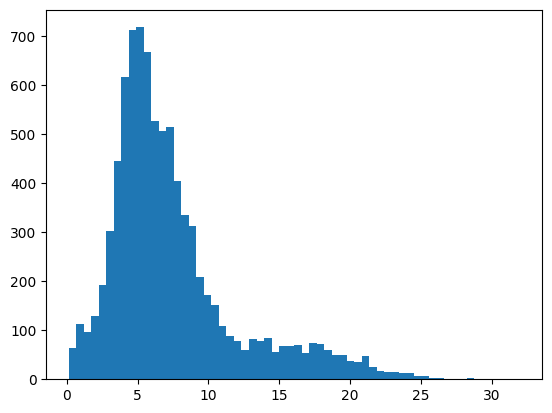

In [157]:
# After running previous cell, all_start_dists has all the distances from ball carrier to tackler at playstart
# for outlier using 1.5IQR + Q3 

all_start_dists = np.array(all_start_dists)

# print(all_start_dists)

quartile_3 = np.percentile(all_start_dists, 75)
quartile_1 = np.percentile(all_start_dists, 25)

print(quartile_1, quartile_3)
#2.3998176158978235 8.170188186099834
# plt.hist(all_start_dists, bins=50)
potential_tackler_threshold = quartile_3 + 1.5*(quartile_3  - quartile_1)
plt.hist(all_start_dists, bins = 60)

In [158]:
df = all_weeks.merge(plays, on=['gameId', 'playId'], how='inner')

In [159]:
(df[df['event'] == "tackle"])

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,preSnapHomeScore,preSnapVisitorScore,passResult,playResult,absoluteYardlineNumber,offenseFormation,defendersInTheBox,expectedPoints,expectedPointsAdded,gameClockSeconds
17,2022090800,56,35472.0,Rodger Saffold,18,2022-09-08 20:24:06.900000,76.0,BUF,left,88.230000,...,0,0,C,6,85,SHOTGUN,6.0,1.298699,0.00442,900
39,2022090800,56,38577.0,Bobby Wagner,18,2022-09-08 20:24:06.900000,45.0,LA,left,78.620000,...,0,0,C,6,85,SHOTGUN,6.0,1.298699,0.00442,900
61,2022090800,56,41239.0,Aaron Donald,18,2022-09-08 20:24:06.900000,99.0,LA,left,91.040000,...,0,0,C,6,85,SHOTGUN,6.0,1.298699,0.00442,900
83,2022090800,56,42392.0,Mitch Morse,18,2022-09-08 20:24:06.900000,60.0,BUF,left,87.200000,...,0,0,C,6,85,SHOTGUN,6.0,1.298699,0.00442,900
105,2022090800,56,42489.0,Stefon Diggs,18,2022-09-08 20:24:06.900000,14.0,BUF,left,79.330000,...,0,0,C,6,85,SHOTGUN,6.0,1.298699,0.00442,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12182551,2022110700,3787,54476.0,Chris Olave,40,2022-11-07 23:06:49.200000,12.0,NO,right,29.140000,...,13,27,R,5,21,SHOTGUN,4.0,0.072230,-0.07223,23
12182595,2022110700,3787,54541.0,Travis Jones,40,2022-11-07 23:06:49.200000,98.0,BAL,right,24.780000,...,13,27,R,5,21,SHOTGUN,4.0,0.072230,-0.07223,23
12182639,2022110700,3787,54606.0,Damarion Williams,40,2022-11-07 23:06:49.200000,22.0,BAL,right,33.450000,...,13,27,R,5,21,SHOTGUN,4.0,0.072230,-0.07223,23
12182683,2022110700,3787,55125.0,Lewis Kidd,40,2022-11-07 23:06:49.200000,66.0,NO,right,23.410000,...,13,27,R,5,21,SHOTGUN,4.0,0.072230,-0.07223,23


In [160]:
print(len(play_nums))

6141


In [161]:
valid = []

def get_name(id):
    return players[players['nflId'] == id]['displayName'].iloc[0]

for game_id, play_id, start_frame, def_club in play_nums:
    #select play
    # print(game_id, play_id)
    curr_play = df[(df['gameId'] == game_id) & (df['playId'] == play_id)]
    #select frames
    max_frame = curr_play['frameId'].max()
    end_frame = curr_play[curr_play['event'] == "tackle"]['frameId'].iloc[0] if not curr_play[curr_play['event'] == "tackle"].empty else max_frame
    play_df = curr_play[(curr_play['frameId'] >= start_frame) & (curr_play['frameId'] <= end_frame)]
    # Filtering offensive players
    off_club = play_df[play_df['club'] != def_club]
    #getting start rows for defensive players
    start_frame_rows = play_df[(play_df['club'] == def_club) & (play_df['frameId'] == start_frame)]
    #ball_carrier_name = start_frame_rows['ballCarrierDisplayName'].iloc[0]
    valid_player_names = [player for player in start_frame_rows['displayName'] if 
                          (math.dist([start_frame_rows[start_frame_rows['displayName'] == player]['x'].iloc[0], 
                                      start_frame_rows[start_frame_rows['displayName'] == player]['y'].iloc[0]],
                                     [off_club[off_club['displayName'] == start_frame_rows['ballCarrierDisplayName'].iloc[0]]['x'].iloc[0], 
                                      off_club[off_club['displayName'] == start_frame_rows['ballCarrierDisplayName'].iloc[0]]['y'].iloc[0]])
                          < potential_tackler_threshold)]
    tackler_ids = tackles[(tackles['gameId'] == game_id) & (tackles['playId'] == play_id)]['nflId']
    tackler_names = tackler_ids.apply(get_name).tolist()
    for name in tackler_names:
        if name not in valid_player_names:
            valid_player_names.append(name)
    def_club_filtered = play_df[play_df['displayName'].isin(valid_player_names)]
    valid.extend([off_club, def_club_filtered])

# Concatenate the results outside the loop


In [162]:
# valid_players is a subset of all_weeks and plays
valid_players = pd.concat(valid)

In [163]:
print(valid_players.columns)

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'playResult',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'expectedPoints', 'expectedPointsAdded', 'gameClockSeconds'],
      dtype='object')


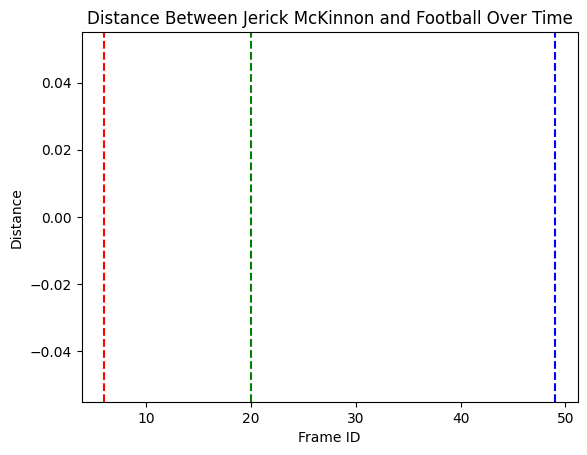

In [164]:
curr_play = df[(df['gameId'] == 2022091110) & (df['playId'] == 1494)]
c = curr_play[(curr_play["displayName"] == "football") | (curr_play["displayName"] == "Jerick McKinnon")]
mckinnon_df = c[c['displayName'] == 'Jerick McKinnon']
football_df = c[c['displayName'] == 'football']
dists = []
for frame in c['frameId'].unique():  # Use unique() to ensure each frame is processed once
    mckinnon_x = mckinnon_df[mckinnon_df["frameId"] == frame]["x"].iloc[0]
    mckinnon_y = mckinnon_df[mckinnon_df["frameId"] == frame]["y"].iloc[0]
    football_x = football_df[football_df["frameId"] == frame]["x"].iloc[0]
    football_y = football_df[football_df["frameId"] == frame]["y"].iloc[0]
    print(frame, [mckinnon_x, mckinnon_y], [football_x, football_y])
    dist = math.dist([mckinnon_x, mckinnon_y], [football_x, football_y])
    dists.append(dist)

# Plotting
plt.plot(c['frameId'].unique(), dists)  # Make sure the frame IDs align with the distances calculated
plt.xlabel('Frame ID')
plt.ylabel('Distance')
plt.title('Distance Between Jerick McKinnon and Football Over Time')
plt.axvline(x=6, color='r', linestyle='--', label='Frame 6')
plt.axvline(x=20, color='g', linestyle='--', label='Frame 20')
plt.axvline(x=49, color='b', linestyle='--', label='Frame 49')
plt.show()

    

In [165]:
valid_players.head(250)
print(valid_players.columns)

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'playResult',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'expectedPoints', 'expectedPointsAdded', 'gameClockSeconds'],
      dtype='object')


In [166]:
# To get distributions, use below Code
# keep in mind that it may have to be subtractive if offense has the def player blocked
# if dist is subtracted from, normalize again to maintain integral = 1

<class 'numpy.ndarray'>


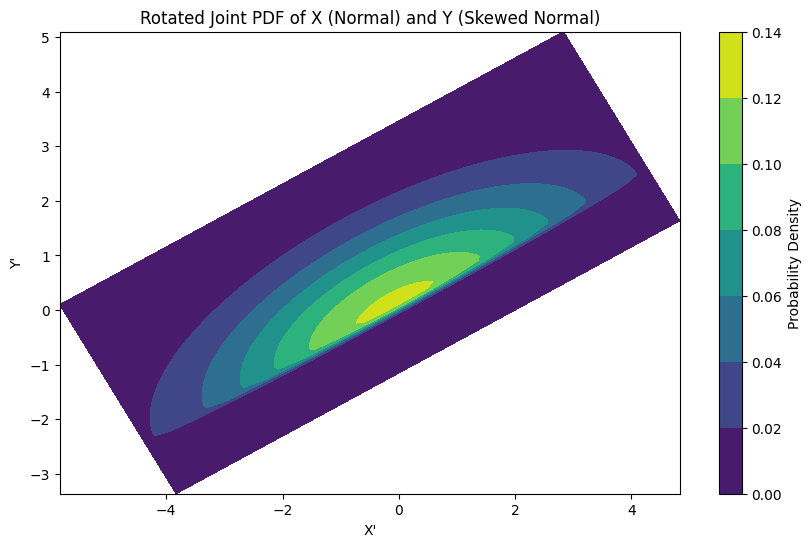

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, norm

def rotate_point(x, y, theta):
    """
    Apply a rotation to a point (x, y) by an angle theta (in radians).
    """
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta), np.cos(theta)]])
    return np.dot(rotation_matrix, np.array([x, y]))

# Number of samples and angle of rotation
n = 1000
theta = np.radians(30)  # Rotate by 45 degrees, for example

# Generate a normal distribution for x
y = np.random.normal(0, 1, n)

# Generate a skewed normal distribution for y
a = 10  # skewness parameter
x = skewnorm.rvs(a, size=n)

# Points for calculating PDFs
x_points = np.linspace(-5, 5, 70)
y_points = np.linspace(-1, 3, 70)
pdf_x_points = norm.pdf(x_points, scale= 5/2)
pdf_y_points = skewnorm.pdf(y_points,20 )

# Creating a meshgrid for the joint distribution
X, Y = np.meshgrid(x_points, y_points)
print(type(pdf_x_points))
# Rotate each point in the meshgrid
X_rot, Y_rot = np.empty_like(X), np.empty_like(Y)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        X_rot[i, j], Y_rot[i, j] = rotate_point(X[i, j], Y[i, j], theta)

# Compute the joint PDF on the rotated grid
joint_pdf_rotated = np.outer(pdf_y_points, pdf_x_points)

# Plotting the rotated joint PDF
plt.figure(figsize=(10, 6))
plt.contourf(X_rot, Y_rot, joint_pdf_rotated, cmap="viridis")
plt.colorbar(label='Probability Density')
plt.title("Rotated Joint PDF of X (Normal) and Y (Skewed Normal)")
plt.xlabel("X'")
plt.ylabel("Y'")
plt.show()

In [168]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def create_football_field():
    """
    Creates a football field for plotting.
    """
    field = plt.figure(figsize=(12, 6.33))
    ax = field.add_subplot(1, 1, 1)

    # Create the green field
    plt.plot([0, 120], [0, 0], color="green")
    ax.set_facecolor('green')

    # Add major lines
    for x in range(10, 110, 10):
        line = patches.Rectangle((x, 0), .1, 53.3, linewidth=1, edgecolor='white', facecolor='white')
        ax.add_patch(line)

    # Add endzones
    endzone1 = patches.Rectangle((0, 0), 10, 53.3, linewidth=1, edgecolor='white', facecolor='blue')
    endzone2 = patches.Rectangle((110, 0), 10, 53.3, linewidth=1, edgecolor='white', facecolor='blue')
    ax.add_patch(endzone1)
    ax.add_patch(endzone2)

    # Set limits and labels
    plt.xlim(0, 120)
    plt.ylim(0, 53.3)
    plt.xlabel('Yards (Length of Field)')
    plt.ylabel('Yards (Width of Field)')
    plt.title('NFL Football Field')
    
    return ax

In [253]:
position_t_info = {
    "DE" : ((7.322719232987062, 0.12881529495845334, 0.6672880475498693, 6.42785426010332, 0.019966113155859003, 0.6477597816301706)),
    "SS" : ((5.107508394561631, 0.06568784144823583, 0.7446880972538361, 4.569412367147843, -0.012239447953968512, 0.8262114794845226)),
    "FS" : ((4.66532319164847, 0.1351910850714022, 0.6842657927545983, 6.06998121022001, -0.0006546715218879895, 0.7795782785182302)),
    "OLB" :((5.273472395245827, 0.10663288071080984, 0.6205551604648218, 7.334952546776893, 0.026189916367707178, 0.6488302045518881)) , 
    "DT" :((5.569558115334946, 0.07408100340712373, 0.6105034874867465, 6.393630032210144, -0.005045181011060849, 0.6302374841727374)) ,
    "CB" :((6.349296636622419, 0.10235641145240083, 0.892232719512297, 5.448775313396228, 0.015871937817115187, 0.7796017896374858)) ,
    "MLB" :((7.13173972579105, 0.12282249024093272, 0.6228963914601275, 6.9587549714459715, 0.011692059600892205, 0.6577565119449411)) }


0.025968224912972175
1390 656 0.10889420641192273 0.19255343877356434
0.014128218015800015
1396 656 0.13293001821556344 0.0960722661842102
0.006974496439390952
1402 656 0.14686970050810103 0.04533480350754726
0.0526610330552616
1390 662 0.09221952180393794 0.36347895758985466
0.028650651264589353
1396 662 0.1125747927016053 0.20287173798120614
0.014143600063903401
1402 662 0.12437992795603595 0.10210251114790798
0.0726789642574274
1390 666 0.0780981879750019 0.48202902881061005
0.03954156495612186
1396 666 0.09533650955541403 0.29316525387334125
0.01951997793961007
1402 666 0.10533395536879579 0.15634251498823928
0.09712626817680951
1390 669 0.0706857405864107 0.5787802010871163
0.052842313884055435
1396 669 0.08628794031693662 0.3798046240016044
0.02608598831228147
1402 669 0.09533650955541367 0.21483653170028988
0.058421382579739986
1399 692 0.09019835381930263 0.39309303054393196
0.040710509913873476
1402 692 0.09855885040841171 0.29231490558773815
0.0374345471571476
1399 698 0.1030

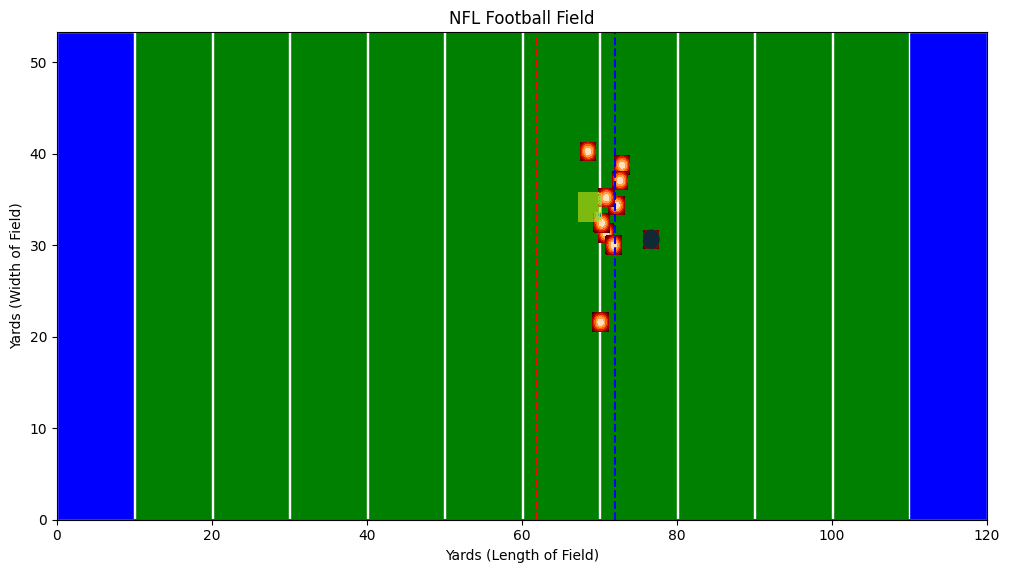

In [272]:

ax = create_football_field()
for game_id, play_id, start_frame, def_club in play_nums:
    off_club = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]['possessionTeam'].iloc[0]
    ydline = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]['absoluteYardlineNumber'].iloc[0]
    yds_to_go = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]['yardsToGo'].iloc[0]
    play_direction = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]['playDirection'].iloc[0]
    firstDownLine = ydline - yds_to_go if play_direction == 'left' else ydline + yds_to_go
    ball_carrier_id = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]['ballCarrierId'].iloc[0]
    

    curr_play_def = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id) & (valid_players['frameId'] == start_frame)
                              & (valid_players['club'] == def_club)]
    curr_play_off = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id) & (valid_players['frameId'] == start_frame)
                              & (valid_players['club'] == off_club)]
    curr_play_football = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id) & (valid_players['frameId'] == start_frame)
                              & (valid_players['club'] != off_club) & (valid_players['club'] != def_club)]
    
    # if (abs(ydline - curr_play_football['x'].iloc[0]) > 4):
    #     ydline = 
    plt.axvline(x=ydline, color='blue', linestyle='--')
    plt.axvline(x=firstDownLine, color='red', linestyle='--')
    offensive_pdf_grid = np.zeros((int(120 * 20), int(53.3 * 20))) # 20 for number of "dots" per yard
    #offensive plotting
    for playerId in curr_play_off['nflId'].unique():
        if (playerId != ball_carrier_id):
            player_data = curr_play_off[curr_play_off['nflId'] == playerId]
            player_x, player_y = player_data['x'].iloc[0], player_data['y'].iloc[0]
            
            x_points = np.linspace(player_x - 1, player_x + 1, 20)
            y_points = np.linspace(player_y - 1, player_y + 1, 20)
            pdf_x_points = norm.pdf(x_points, loc = player_x, scale = 1)
            pdf_y_points = norm.pdf(y_points, loc = player_y, scale=1)

            X, Y = np.meshgrid(x_points, y_points)
            joint_pdf = np.outer(pdf_y_points, pdf_x_points)
            for i in range(len(joint_pdf)):
                for j in range(len(joint_pdf[i])):
                    grid_x_index = int(X[i, j] * 20)
                    grid_y_index = int(Y[i, j] * 20)
                    if (0 <= grid_x_index) and (0 <= grid_y_index) and (grid_x_index <= 120 * 20) and (grid_y_index <= 53.3 * 20):
                        offensive_pdf_grid[grid_x_index][grid_y_index] += joint_pdf[i][j]
                    if joint_pdf[i][j] < .05:
                        joint_pdf[i][j] = np.NaN
            
            ax.contourf(X, Y, joint_pdf, cmap="gist_heat", alpha=1)
        else:
            ball_carrier = patches.Circle((player_x, player_y), 1, color = '#102934')
            ax.add_patch(ball_carrier)
    #defensive plotting
    for playerId in curr_play_def['nflId'].unique():

        defender = curr_play_def[curr_play_def['nflId'] == playerId]
        player_x,player_y,player_speed = defender['x'].iloc[0], defender['y'].iloc[0], defender['s'].iloc[0]
        player_dir = np.radians(defender['dir'].iloc[0])
        player_pos = players[players['nflId'] == playerId]['position'].iloc[0]
    
        #making the distribution
        x_df, x_mu, x_sigma, y_df, y_mu, y_sigma = position_t_info[player_pos]
        t_score_x = t.ppf(0.975, x_df)
        t_score_y = t.ppf(0.975, y_df)
        x,y = player_x + x_mu, player_y + y_mu

        x_points = np.linspace(x - (x_sigma*t_score_x), x + (x_sigma*t_score_x), 20)
        y_points = np.linspace(y - (y_sigma*t_score_y), y + (y_sigma*t_score_y),  20)

        pdf_x_points = t.pdf(x_points, df=x_df, loc=x, scale=x_sigma)
        pdf_y_points = t.pdf(y_points, df=y_df, loc=y, scale=y_sigma) 
        # Creating a meshgrid for the joint distribution
        X, Y = np.meshgrid(x_points, y_points)

        joint_pdf = np.outer(pdf_y_points, pdf_x_points)

        # Plotting the rotated joint PDF
        for i in range(len(joint_pdf)):
            for j in range(len(joint_pdf[i])):
                grid_x_index = int(X[i, j] * 20)
                grid_y_index = int(Y[i, j] * 20)
                # print(offensive_pdf_grid[grid_x_index][grid_y_index], joint_pdf[i][j])
                if (offensive_pdf_grid[grid_x_index][grid_y_index] > 0):
                    print(joint_pdf[i][j])
                joint_pdf[i][j] = (joint_pdf[i][j]) / (offensive_pdf_grid[grid_x_index][grid_y_index] +joint_pdf[i][j])
                if (offensive_pdf_grid[grid_x_index][grid_y_index] > 0):
                    print(grid_x_index, grid_y_index, offensive_pdf_grid[grid_x_index][grid_y_index],joint_pdf[i][j] )
                if joint_pdf[i][j] < .05:
                    joint_pdf[i][j] = np.NaN

        ax.contourf(X, Y, joint_pdf, cmap="viridis", alpha=0.6)
        break
    # football_x, football_y = curr_play_football['x'].iloc[0], curr_play_football['y'].iloc[0]
    # football = patches.Ellipse((football_x, football_y), 3, 2, color='brown')
    # ax.add_patch(football)
    break
    

2.4934917652489994 2.4108545153086225


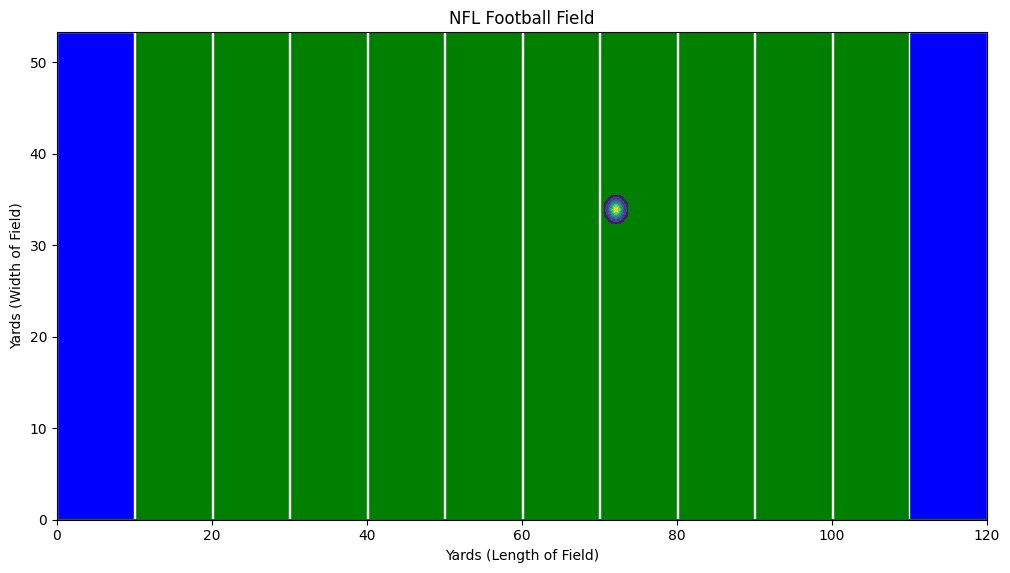

In [255]:
#getting data
from pprint import pprint
from scipy.stats import t
ax = create_football_field()

game_id, play_id = 2022090800,101
curr_play = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]
nfl_id = 43335
defender = curr_play[curr_play['nflId'] == nfl_id]
x,y,s,d,p = defender['x'].iloc[0], defender['y'].iloc[0], defender['s'].iloc[0], np.radians(defender['dir'].iloc[0]), players[players['nflId'] == nfl_id]['position'].iloc[0]

#making the distribution
x_df, x_mu, x_sigma, y_df, y_mu, y_sigma = position_t_info[p]
t_score_x = t.ppf(0.975, x_df)
t_score_y = t.ppf(0.975, y_df)
x,y = x + x_mu, y + y_mu
print(t_score_x, t_score_y)
x_points = np.linspace(x - (x_sigma*t_score_x), x + (x_sigma*t_score_x), 100)
y_points = np.linspace(y - (y_sigma*t_score_y), y + (y_sigma*t_score_y),  100)

pdf_x_points = t.pdf(x_points, df=x_df, loc=x, scale=x_sigma)
pdf_y_points = t.pdf(y_points, df=y_df, loc=y, scale=y_sigma)

X, Y = np.meshgrid(x_points, y_points)

# Compute the joint PDF on the rotated grid
joint_pdf = np.outer(pdf_y_points, pdf_x_points)
# print(np.count(joint_pdf))
# Plotting the rotated joint PDF
for i in range(len(joint_pdf)):
    for j in range(len(joint_pdf[i])):
        if joint_pdf[i][j] < .02:
            joint_pdf[i][j] = np.NaN

#plotting jawn
ax.contourf(X, Y, joint_pdf, cmap="viridis", alpha=1)



In [173]:
import math
import matplotlib.pyplot as plt
from scipy.integrate import simps

def chaseDownEfficiency(frames, dists):
    #get integral
    decreasing = True
    integral = 0
    window_x = 0
    x_data = np.array(frames)
    y_data = np.array(dists)
    for idx in range(1, len(x_data)):
        #distance starts increasing
        if (y_data[idx] > y_data[idx - 1]) and (decreasing == True):
            indices = (x_data >= window_x + x_data[0]) & (x_data <= idx + x_data[0])
            x_subset = x_data[indices]
            y_subset = y_data[indices]
            factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset) #better weight for big distance covered in less time
            integral += simps(y_subset, x_subset) * factor
            window_x = idx
            decreasing = False
        #distance starts decreasing, 
        elif (y_data[idx] <= y_data[idx - 1]) and (decreasing == False):
            indices = (x_data >= window_x + x_data[0]) & (x_data <= idx + x_data[0])
            x_subset = x_data[indices]
            y_subset = y_data[indices]
            factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset)
            integral -= simps(y_subset, x_subset) * (factor)
            window_x = idx
            decreasing = True
    #for last section
    indices = (x_data >= window_x + x_data[0]) & (x_data <= x_data[-1])
    x_subset = x_data[indices]
    y_subset = y_data[indices]
    factor = abs(y_subset[0] - y_subset[-1]) / len(x_subset)
    integral += (simps(y_subset, x_subset) * factor) if decreasing else -(simps(y_subset, x_subset) * factor)
    #get chasedown efficiency
    return integral

for game_id, play_id, start_frame, def_club in play_nums:

    curr_play = valid_players[(valid_players['gameId'] == game_id) & (valid_players['playId'] == play_id)]
    curr_play_def = curr_play[curr_play['club'] == def_club]
    ball_carrier_id = plays['ballCarrierId'].iloc[0]
    ball_carrier = curr_play[curr_play['nflId'] == ball_carrier_id]

    for defender in curr_play_def['displayName'].unique():
        distances = []
        defender_data = curr_play_def[curr_play_def['displayName'] == defender]
        #print(defender_data)
        for frame in defender_data['frameId']:
            defender_frame_data = defender_data[defender_data['frameId'] == frame]
            ball_carrier_frame_data = ball_carrier[ball_carrier['frameId'] == frame]

            # Assuming there's always exactly one row per frame for both defender and ball carrier
            defender_x, defender_y = defender_frame_data.iloc[0]['x'], defender_frame_data.iloc[0]['y']
            ball_carrier_x, ball_carrier_y = ball_carrier_frame_data.iloc[0]['x'], ball_carrier_frame_data.iloc[0]['y']

            # Calculate the distance
            distance = math.dist([defender_x, defender_y], [ball_carrier_x, ball_carrier_y])
            distances.append(distance)
            
        # # Plotting distance over frames
        # print(defender_data['frameId'])
        # print(distances)
       # plt.plot(defender_data['frameId'], distances, label=f'Defender {defender}')
        chaseDown = chaseDownEfficiency(defender_data['frameId'], distances)
        
        # plt.xlabel('Frame')
        # plt.ylabel('Distance to Ball Carrier')
        # plt.title(f'Distance from Defender {defender} to the Ball Carrier Over Time, Play: {game_id} {play_id}')
        # #plt.title(f'Distance from Defender {defender} to the Ball Carrier Over Time, Play: {game_id} {play_id}, chasedown efficiency: {chaseDown}')
        # plt.legend()
        # plt.show()



2022091800 1188
2022091801 3659
2022091808 586
2022091810 475
2022091805 1869
2022100212 1941
2022100204 1222
2022100908 619
2022101601 3676
2022101603 3664
2022101608 3206
2022102310 3487
2022100908 390
2022101603 4087
2022103100 2428
2022100913 293
2022091809 2069
2022091113 200
2022101608 557
2022110609 2736


In [ ]:
print(len(chas))

In [ ]:
dumb_play = valid_players[(valid_players['gameId'] == 2022091110) & (valid_players['playId'] == 1494)]
dumb_play



,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,preSnapHomeScore,preSnapVisitorScore,passResult,playResult,absoluteYardlineNumber,offenseFormation,defendersInTheBox,expectedPoints,expectedPointsAdded,gameClockSeconds


In [ ]:
plays[(plays['gameId'] == 2022091110) & (plays['playId'] == 1494)]

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,down,yardsToGo,possessionTeam,defensiveTeam,yardlineNumber,preSnapHomeScore,preSnapVisitorScore,passResult,playResult,absoluteYardlineNumber,offenseFormation,defendersInTheBox,expectedPoints,expectedPointsAdded,gameClockSeconds
9744,2022091110,1494,41325,Jerick McKinnon,(6:03) J.McKinnon left tackle to KC 30 for 5 y...,1,10,KC,ARI,25,7,20,R,5,35,SINGLEBACK,8.0,1.027727,-0.205625,363


In [ ]:
found = any(tup[0] == 2022091110 and tup[1] == 1494 for tup in play_nums)
print("Tuple found" if found else "Tuple not found")

Tuple found
